In [74]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn import under_sampling, over_sampling 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss


%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_columns',500)
sns.set()

import random

SEED = 27
random.seed(SEED)
np.random.seed(SEED)


In [75]:
p = Path.cwd()
data_path = p.parent.parent / 'data' / 'Master Project Data' 
nfirs_path =  data_path / 'NFIRS Fire Incident Data.csv'

cols_to_use = ['State','FDID','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','GEOID']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)






In [76]:
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')
nfirs['10k_loss'] = np.where(nfirs['tot_loss']>=10000,'had_10k_loss','no_10k_loss')


In [77]:
nfirs['GEOID'] = (nfirs['GEOID'].str[:-3].str.zfill(11))
nfirs['year'] = nfirs['inc_date'].dt.year.astype('str')
nfirs['GEOID'].str.len().value_counts()
# Add a year column to be used to groupby in addition to GEOID


11.0    1699998
Name: GEOID, dtype: int64

In [78]:
nfirs['GEOID'].head()

0    02110000500
1    02110000600
2    02110000100
3    02110000400
4    02110000400
Name: GEOID, dtype: object

In [79]:
#nfirs =  nfirs[~ nfirs['GEOID'].isna()]
nfirs['GEOID'].str[:2].unique()

array(['02', nan, '01', '05', '04', '06', '08', '09', '11', '10', '12',
       '13', '15', '19', '16', '17', '18', '20', '21', '22', '25', '24',
       '23', '26', '27', '29', '28', '30', '37', '38', '31', '33', '34',
       '35', '32', '36', '39', '40', '41', '42', '44', '45', '46', '47',
       '48', '49', '51', '50', '53', '55', '54', '56'], dtype=object)

In [80]:
fires =  pd.crosstab(nfirs['GEOID'],nfirs['year'])
fires.head()

year,2009,2010,2011,2012,2013,2014,2015,2016
GEOID,,,,,,,,
01001020100,3,3,0,2,1,0,2,2
01001020200,4,1,5,1,2,1,2,1
01001020300,4,3,3,2,4,1,4,4
01001020400,8,1,4,0,3,1,4,1
01001020500,6,8,7,4,8,4,13,11


In [82]:
fires.describe(percentiles=[.75, .85, .9 ,.95, .99])

year,2009,2010,2011,2012,2013,2014,2015,2016
count,69672.000000,69672.000000,69672.000000,69672.000000,69672.000000,69672.000000,69672.000000,69672.000000
mean,2.851174,3.038480,2.779065,2.796891,2.946693,3.342232,3.289499,3.355982
std,4.113418,4.358031,3.977128,3.947763,4.026929,4.437296,4.309103,4.657149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000
85%,6.000000,6.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000
90%,7.000000,7.000000,7.000000,7.000000,7.000000,8.000000,8.000000,8.000000
95%,10.000000,10.000000,9.000000,9.000000,10.000000,11.000000,10.000000,11.000000
99%,19.000000,19.000000,17.000000,18.000000,18.000000,20.000000,19.000000,20.000000


In [83]:
def plotFires(df):

    #g = sns.FacetGrid(nfirs,col = 'year' , row = 'GEOID', aspect=.25)
    #g.map(sns.distplot())
    figsize = (20, 16)
    cols = 4
    rows = 2
    f, axs = plt.subplots(cols,rows,figsize= figsize)



    cases = df.columns.to_list()
    for  case in enumerate(cases):
        ax = plt.subplot(cols,rows,case[0]+1)
        ax.set_title('All Fires {}'.format(str(case[1])) )
        plt.hist(df[case[1]],bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,20,40,80,100])
        #plt.hist(df[case[1]])





In [84]:
top10 = fires > fires.quantile(.9)


In [85]:
top10.sum() / top10.shape[0] * 100

year
2009    8.639052
2010    9.494488
2011    8.148180
2012    8.270180
2013    8.746699
2014    8.217074
2015    7.928580
2016    8.133827
dtype: float64

In [86]:
high2009 = fires[ fires['2009'] > 7] 

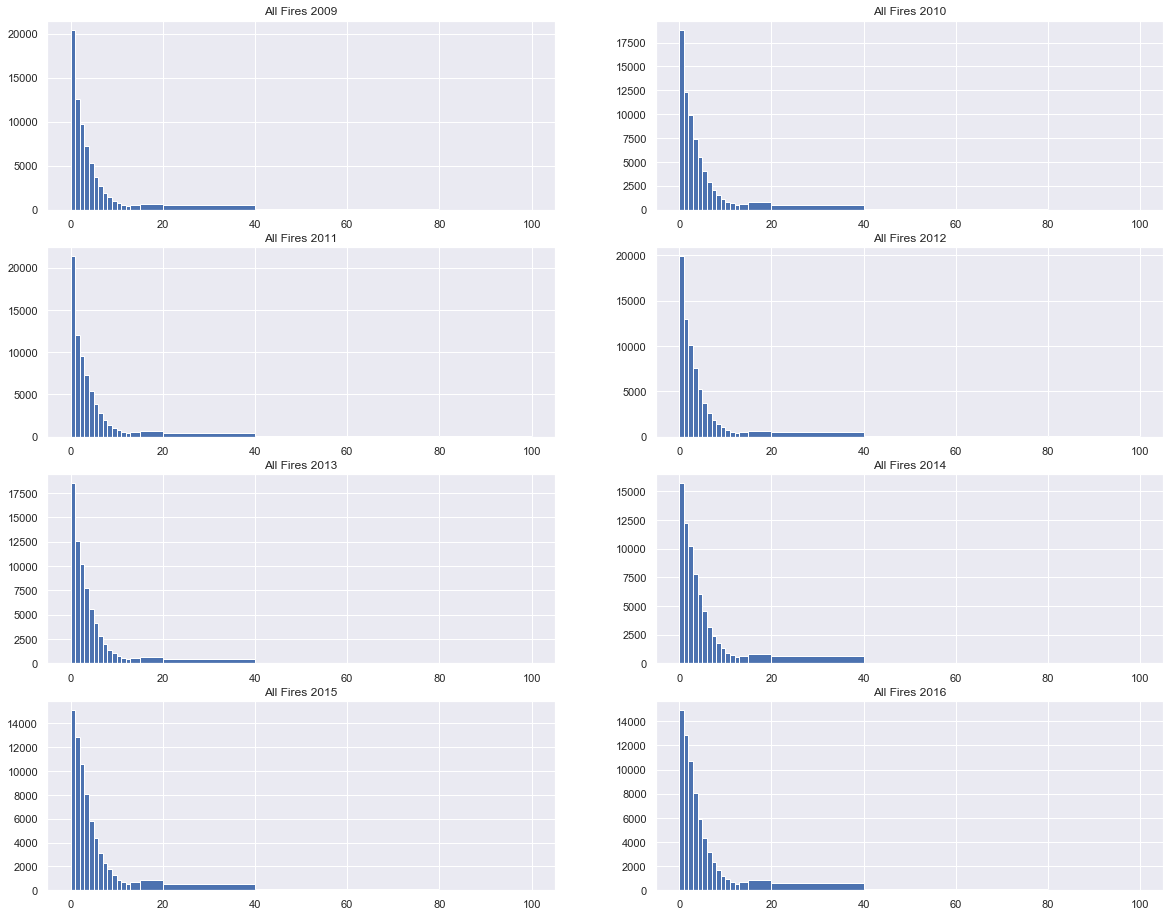

In [87]:
plotFires(fires)

In [88]:
def resample_df(X,y,upsample=True ,seed = SEED):
    from sklearn.utils import resample
    # check which of our two classes is overly represented 
    if np.mean(y) > .5:
        major,minor = 1,0
    else:
        major,minor = 0, 1
    
    X['Class'] = y
    
    df_major = X[X.Class == major ]
    df_minor = X[X.Class == minor ]
    
    
    if upsample:      

        df_minor_resampled = resample(df_minor,
                                     replace = True,
                                     n_samples = df_major.shape[0],
                                     random_state = seed)
    
    
   
        combined = pd.concat([df_major,df_minor_resampled])
        
        # Debug
        print('minor class {}, major class {}'.format(df_minor_resampled.shape[0],
                                                       df_major.shape[0]))
    
        
    else: # downsample
         
        df_major_resampled = resample(df_major,
                                     replace = False,
                                     n_samples = df_minor.shape[0],
                                     random_state = seed)
        
        
        combined = pd.concat([df_major_resampled,df_minor])
        
        print('minor class {}, major class {}'.format(df_minor.shape[0],
                                                      df_major_resampled.shape[0]))


    
    
    print(combined.columns)
    y_out = combined['Class']
    X_out = combined.drop('Class', axis =1 )
    return X_out , y_out

In [89]:
def train_model(fires,top10,nyears = 4,modeltype='LogisticRegression',resample = False, seed = SEED):
    from scipy.stats import zscore
    
    years = fires.columns
        
    start_pointer = 0
    end_pointer = nyears-1
    y_pointer = nyears
    
    
    if modeltype =='LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(warm_start=True,
                                   class_weight = 'balanced')
    
    elif modeltype =='SVM':
        from sklearn.svm import SVC
        model = SVC(
            gamma='auto',
            kernel='linear',
            class_weight = 'balanced',
            random_state=SEED)
        
    elif modeltype =='Bagged':# WIP
        from imblearn.ensemble import BalancedBaggingClassifier
        model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    sampling_strategy='auto',
                                    replacement=False,
                                    random_state=0)

    elif modeltype == 'NN':
        model = MLPClassifier(hidden_layer_sizes=(nyears,nyears ),
                              activation='relu', 
                              solver='adam',
                              max_iter=500)
    

        
    while y_pointer < len(years):
        X_start, X_end = start_pointer, end_pointer
       
        X = fires.iloc[:,X_start:X_end].copy()
        
        L = X.shape[1] 
        X.columns = ['year-{}'.format(L - year) for year in range(L)]
        
        sm = np.sum(X, axis = 1 )
        mu = np.mean(X, axis = 1)
        md = np.median(X, axis = 1)
        mx = np.max(X, axis =1)
        X['Sum']  = sm
        X['Mean'] = mu
        X['Median'] =md
        X['Max']  = mx
       # X = X[['Max','Median','Sum']]
        y = top10.iloc[:,y_pointer]
        
    
    
        
        if resample:
            X,y = resample_df(X,y)
        
        #X = zscore(X.astype(float), axis=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2 )
        

        
        print('Predicting {}:'.format(years[y_pointer]) )
        model = model.fit(X_train,y_train)
        predictions = model.predict(X_test)

     
        print(classification_report(y_test,predictions))
        print(log_loss(y_test,predictions))
        
        start_pointer += 1
        end_pointer += 1
        y_pointer += 1
        
      
    feature_importance = {}
    for coef, feat in zip(abs(model.coef_[0]),X.columns.tolist()):
        feature_importance[feat] = coef
        
    return model, feature_importance,X_test,y_test
        
        








minor class 63583, major class 63583
Index(['year-3', 'year-2', 'year-1', 'Sum', 'Mean', 'Median', 'Max', 'Class'], dtype='object')
Predicting 2013:
              precision    recall  f1-score   support

       False       0.78      0.85      0.81     12710
        True       0.84      0.77      0.80     12724

    accuracy                           0.81     25434
   macro avg       0.81      0.81      0.81     25434
weighted avg       0.81      0.81      0.81     25434

6.669083482773534
minor class 63952, major class 63952
Index(['year-3', 'year-2', 'year-1', 'Sum', 'Mean', 'Median', 'Max', 'Class'], dtype='object')
Predicting 2014:
              precision    recall  f1-score   support

       False       0.79      0.85      0.82     12777
        True       0.84      0.77      0.80     12804

    accuracy                           0.81     25581
   macro avg       0.81      0.81      0.81     25581
weighted avg       0.81      0.81      0.81     25581

6.564600526530861
minor class 

In [90]:
mdl,features,X_test,y_test =train_model(fires,top10,4,resample = False)

Predicting 2013:
              precision    recall  f1-score   support

       False       0.97      0.85      0.91     12698
        True       0.33      0.76      0.46      1237

    accuracy                           0.84     13935
   macro avg       0.65      0.80      0.68     13935
weighted avg       0.92      0.84      0.87     13935

5.5545715620517715
Predicting 2014:
              precision    recall  f1-score   support

       False       0.98      0.85      0.91     12825
        True       0.31      0.76      0.44      1110

    accuracy                           0.85     13935
   macro avg       0.64      0.81      0.68     13935
weighted avg       0.92      0.85      0.87     13935

5.294317906532388
Predicting 2015:
              precision    recall  f1-score   support

       False       0.98      0.85      0.91     12887
        True       0.30      0.78      0.43      1048

    accuracy                           0.85     13935
   macro avg       0.64      0.82      0

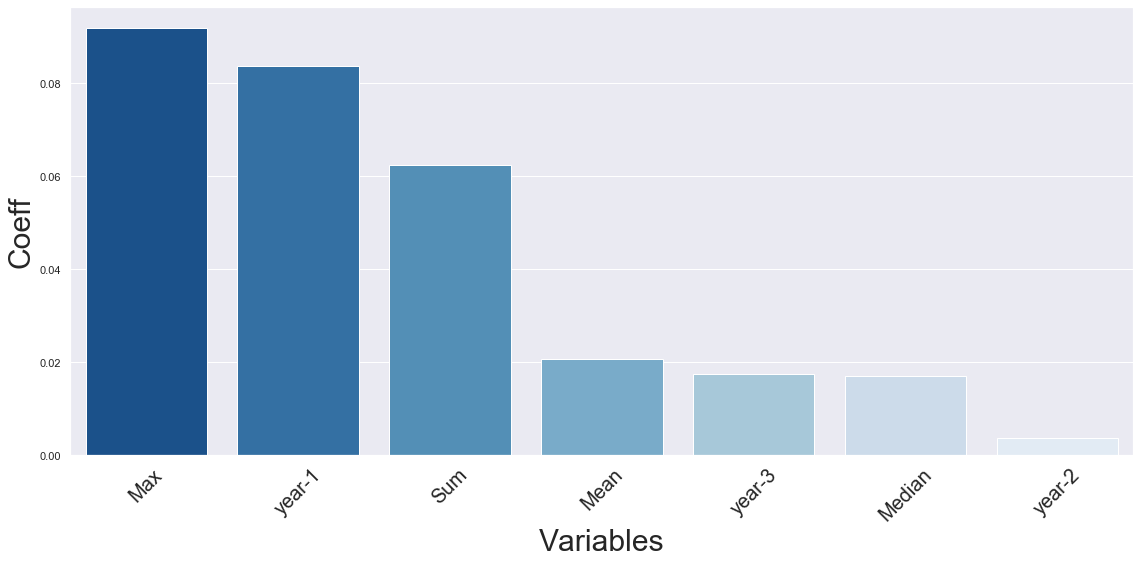

In [91]:
# let's now visualize this
data_to_plot = pd.DataFrame.from_dict(features,orient ='index').reset_index()
data_to_plot.columns = ['Variables','Importance Coefficients']
data_to_plot = data_to_plot.sort_values('Importance Coefficients', ascending=False )

plt.figure(figsize=(16, 8))
sns.barplot(
    x='Variables', y='Importance Coefficients',
    data=data_to_plot, palette='Blues_r')
plt.xticks(
    range(len(data_to_plot)),
    data_to_plot['Variables'], rotation='45', size=20)
plt.xlabel('Variables', fontsize=30)
plt.ylabel('Coeff', fontsize=30)
plt.tight_layout()
plt.show()

In [92]:
def plot_boundaries(X,y,model,n):
        
    from itertools import combinations
    n_elms = max(y.shape[0],1000) # only plot 1000 elements from each class
    
    n_cols = np.ceil(np.sqrt(n))
    n_rows = np.ceil(n / n_cols)

    names = X.columns
    combos = [c for c in combinations(range(X.shape[1]), 2) ]
    
    W = model.coef_[0]
        

    b = model.intercept_
    
    for c in enumerate(combos[:n]):
        x_idx = c[1][0]
        y_idx = c[1][1]
        plot_num = c[0]
            
            
        print('subplot{} {}: {}'.format(n_rows,n_cols,c[0]))
        plt.subplot(n_rows,n_cols,c[0]+1)
        plt.scatter(X.iloc[:n_elms, x_idx],
                    X.iloc[:n_elms, y_idx],
                    c=y[:n_elms], edgecolors='k',
                    alpha = .3, cmap=plt.cm.binary)
        
        ax = plt.gca()

        x_values = np.array(ax.get_xlim())
        y_values = -(b + np.dot(W[x_idx],x_values)) / W[y_idx]

        plt.plot(x_values, y_values )


        plt.xticks(())
        plt.xlabel(names[x_idx])
        plt.yticks(())
        plt.ylabel(names[y_idx])
    plt.show()

    
    
    
    
    
    
    